In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.measurement_models import transmission_rpi, capture_yield_rpi

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

In [3]:
#current_dir = os.path.dirname(os.path.realpath(__file__))
current_dir = './'
print(f'Data directory: {current_dir}')

save_cases_dir = current_dir + 'syn_data_10/'
print(f'Data save directory: {save_cases_dir}')

# how many cases to generate
N_samples = 1

# all options to run! 
settings = {
    'path_to_SAMMY_exe': '/home/fire/SAMMY/sammy/build/install/bin/sammy',
    'path_to_SAMMY_temps': os.path.join(current_dir, 'sammy_temps/'), # relative to current directory!
    'keep_runDIR_SAMMY': True,
    'shell_SAMMY': 'bash',
    'running_path': current_dir
}

Data directory: ./
Data save directory: ./syn_data_10/


## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [4]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)

# energy_range_all = [150, 6000]
energy_range_all = [202, 227]

delta_E = 5
energy_range_larger = [np.min(energy_range_all)-delta_E, np.min(energy_range_all)+delta_E]

In [5]:
### 1mm capture data
capdat1 = sammy_functions.readlst(os.path.join(current_dir, "yield_ta1b_unsmooth.dat"))
capdat1 = capdat1.loc[(capdat1.E<max(energy_range_all)) & (capdat1.E>min(energy_range_all)), :]
capdat1_egrid = np.sort(capdat1.E.values)
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                
                                energy_grid = capdat1_egrid ,

                                #energy_range = energy_range_all,
                                energy_range = None,

                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )

#capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]



### 2mm capture data
capdat2 = sammy_functions.readlst(os.path.join(current_dir, "yield_ta2_unsmooth.dat"))
capdat2 = capdat2.loc[(capdat2.E<max(energy_range_all)) & (capdat2.E>min(energy_range_all)), :]
capdat2_egrid = np.sort(capdat2.E.values)

expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                
                                #energy_range = energy_range_all,
                                
                                energy_range = None,
                                energy_grid = capdat2_egrid,
                                
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
# capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]

### 1mm Transmission data
transdat1 = sammy_functions.readlst(os.path.join(current_dir, "trans-Ta-1mm.twenty"))
transdat1_covfile = os.path.join(current_dir, 'trans-Ta-1mm.idc')

transdat1 = transdat1.loc[(transdat1.E<max(energy_range_all)) & (transdat1.E>min(energy_range_all)), :]
transdat1_egrid = np.sort(transdat1.E.values)

chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)

exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 

                               #energy_range = energy_range_all,
                               energy_grid = transdat1_egrid,
                               energy_range = None,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                               )
#transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst(os.path.join(current_dir, "trans-Ta-3mm.twenty"))
transdat3_covfile = os.path.join(current_dir, "trans-Ta-3mm.idc")

transdat3 = transdat3.loc[(transdat3.E<max(energy_range_all)) & (transdat3.E>min(energy_range_all)), :]
transdat3_egrid = np.sort(transdat3.E.values)

exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               
                               energy_range = None,
                               energy_grid = transdat3_egrid,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
#transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst(os.path.join(current_dir, "trans-Ta-6mm.twenty"))
transdat6_covfile = os.path.join(current_dir, "trans-Ta-6mm.idc")

transdat6 = transdat6.loc[(transdat6.E<max(energy_range_all)) & (transdat6.E>min(energy_range_all)), :]
transdat6_egrid = np.sort(transdat6.E.values)

exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = None, #energy_range_all,

                               energy_grid = transdat6_egrid,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
#transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]

### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


print()

print('Energy grids:')
print(f'len\t first..last')

print(f'{len(capdat1)}\t{expcap1.energy_grid[0]} .. {expcap1.energy_grid[-1]}\t')
print(f'{len(capdat2)}\t{expcap2.energy_grid[0]} .. {expcap2.energy_grid[-1]}')

print(f'{len(transdat1)}\t{exptrans1.energy_grid[0]} .. {exptrans1.energy_grid[-1]}')
print(f'{len(transdat3)}\t{exptrans3.energy_grid[0]} .. {exptrans3.energy_grid[-1]}')
print(f'{len(transdat6)}\t{exptrans6.energy_grid[0]} .. {exptrans6.energy_grid[-1]}\t{exptrans6.energy_range}')
# print(exptrans3.energy_grid)
# print(exptrans6.energy_grid)

print()


Energy grids:
len	 first..last
127	202.0665136529 .. 226.8412350493	
127	202.0665136529 .. 226.8412350493
199	202.0369812628 .. 226.9092922115
199	202.0369812628 .. 226.9092922115
199	202.0369812628 .. 226.9092922115	[202.0369812628, 226.9092922115]



In [6]:
### plotting function
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:

        ax.set_xscale('log')
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig


# little bit modified

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[], f_model_name='fit',
    priors=[], priors_chi2=[], pr_model_name='prior',
    true=[], true_chi2=[], t_model_name ='true',
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (12,9)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=f'{colors[i]}', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'{f_model_name} {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'{f_model_name} {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'{pr_model_name} {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'{pr_model_name} {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'{t_model_name} {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'{t_model_name} {exp.title}'
                
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{'+f'{t_model_name}'+'}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{pr_model_name}'+'}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{f_model_name}'+'}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

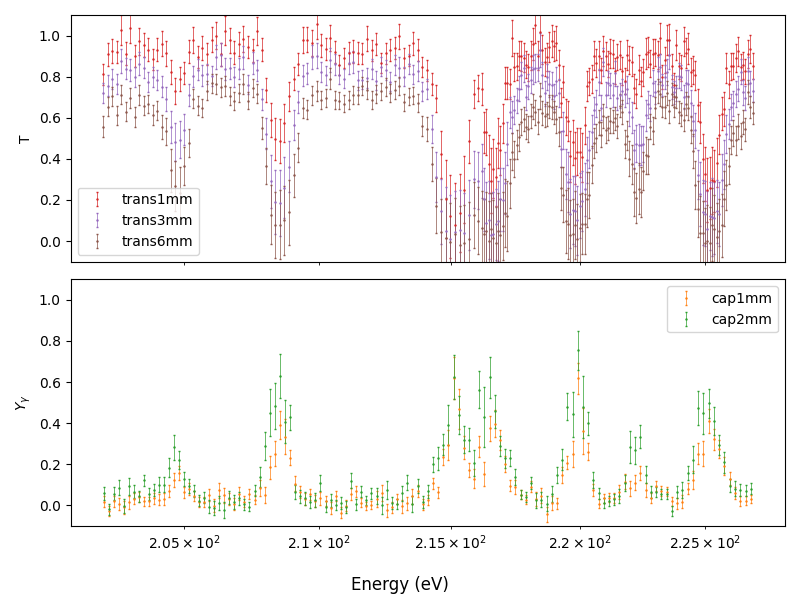

In [7]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]

covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []

for data, exp in zip(datasets, experiments):
    filepath = f'/Users/noahwalton/Documents/GitHub/ATARI/examples/Ta181_Analysis/template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)


fig = plot(datasets, experiments)
fig.tight_layout()

In [8]:
## Could also plot covariance here



In [9]:
sammypath = '/home/fire/SAMMY/sammy/build/install/bin/sammy'

## Fit from ENDF or JEFF

In [10]:
sammyRTO = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : False
                              })

matnum = 7328

# endf8_file = "/Users/noahwalton/research_local/data/ENDF-B-VIII.0_neutrons/n-073_Ta_181.endf"
# endf8_file = "n-073_Ta_181.endf"
# endf8_parameters = sammy_functions.get_endf_parameters(endf8_file, matnum, sammyRTO)

# endf8_parameters = endf8_parameters[(endf8_parameters.E<max(energy_range_all)+5) & (endf8_parameters.E>min(energy_range_all)-5)]

# endf8_parameters["varyGn1"] = np.ones(len(endf8_parameters))
# endf8_parameters["varyGg"] = np.ones(len(endf8_parameters))*1
# endf8_parameters["varyE"] = np.ones(len(endf8_parameters))

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<max(energy_range_all)+5) & (endf_parameters.E>min(energy_range_all)-5)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*1
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

#jeff_file = "/Users/noahwalton/Documents/GitHub/ATARI/examples/Ta181_Analysis/73-Ta-181g.jeff33"
jeff_file = "73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+5) & (jeff_parameters.E>min(energy_range_all)-5)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,1.0,1.0,2.0


In [11]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=1,       # highest order l-wave to consider
                        total_energy_range = energy_range_all, # TODO: ask Noah if that is correct to use this number... because 
)

# Ta_pair.add_spin_group(Jpi='3.0',
#                        J_ID=1,
#                        D_avg=8.79,
#                        Gn_avg=46.5,
#                        Gn_dof=1,
#                        Gg_avg=64.0,
#                        Gg_dof=1000)

# Ta_pair.add_spin_group(Jpi='4.0',
#                        J_ID=2,
#                        D_avg=4.99,
#                        Gn_avg=35.5,
#                        Gn_dof=1,
#                        Gg_avg=64.0,
#                        Gg_dof=1000)


Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=9.003,
                       Gn_avg=452.56,
                       Gn_dof=1,
                       Gg_avg=32.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=8.3,
                       Gn_avg=332.24,
                       Gn_dof=1,
                       Gg_avg=32.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              # "sammy_runDIR": os.path.realpath("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/ATARI_workspace/sammyrunDIR")
                              "sammy_runDIR": os.path.realpath("/home/fire/py_projects/ATARI_YW_newstruct/ATARI/examples/Ta181_Analysis/sammy_rundir_py_gen")
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.05
    )



In [12]:
#Ta_pair.l_max = 5
Ta_pair.map_quantum_numbers(print_out=True)

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [13]:
Ta_pair.spin_groups#['3.0']

{'3.0': {'J_ID': 1,
  '<D>': 9.003,
  '<Gn>': 452.56,
  'n_dof': 1,
  '<Gg>': 32.0,
  'g_dof': 1000,
  'D01': 1.0184333135415622,
  'D99': 21.80043460630884,
  'Gn01': 0.07109168097561466,
  'Gn99': 3002.688805758161,
  'Gg01': 28.765198301747624,
  'Gg99': 35.42300781927096,
  'Gt01': 28.83628998272324,
  'Gt99': 3038.111813577432},
 '4.0': {'J_ID': 2,
  '<D>': 8.3,
  '<Gn>': 332.24,
  'n_dof': 1,
  '<Gg>': 32.0,
  'g_dof': 1000,
  'D01': 0.9389088639781148,
  'D99': 20.098145866085016,
  'Gn01': 0.05219086991191934,
  'Gn99': 2204.378046723288,
  'Gg01': 28.765198301747624,
  'Gg99': 35.42300781927096,
  'Gt01': 28.817389171659542,
  'Gt99': 2239.801054542559}}

In [14]:
# sammyOUT_JEFF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [15]:
# sammyINPyw.resonance_ladder = endf_parameters
# sammyOUT_ENDF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [16]:
# sammyINPyw.resonance_ladder = endf8_parameters
# sammyOUT_ENDF8 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

## Now Generate Syndat

In [17]:
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT


trans1mm_gen_meas = Transmission_RPI(trigo=(10000000, 0.0),
                                     trigs=(15000000, 0.0))
trans1mm_red_meas = Transmission_RPI(trigo=(10000000, 0.0),
                                     trigs=(15000000, 0.0))

trans3mm_gen_meas = Transmission_RPI(trigo=(10000000, 0),
                                     trigs=(15000000, 0))
trans3mm_red_meas = Transmission_RPI(trigo=(10000000, 0),
                                     trigs=(15000000, 0))

trans6mm_gen_meas = Transmission_RPI(trigo=(10000000, 0.0),
                                     trigs=(15000000, 0.0))
trans6mm_red_meas = Transmission_RPI(trigo=(10000000, 0.0),
                                     trigs=(15000000, 0.0))

cap1mm_gen_meas = Capture_Yield_RPI(trig_g     =  (1000000,   0),
                                    trig_bg    =  (100000,  0),
                                    trig_f     =  (1000000,   0),
                                    trig_bf    =  (100000,  0)
                                    )
cap1mm_red_meas = Capture_Yield_RPI(trig_g     =  (1000000,   0),
                                    trig_bg    =  (100000,  0),
                                    trig_f     =  (1000000,   0),
                                    trig_bf    =  (100000,  0)
                                    )

# cap1mm_gen_meas = Capture_Yield_RPI(trig_g     =  (100000000,   0),
#                                     trig_bg    =  (10000000,  0),
#                                     trig_f     =  (100000000,   0),
#                                     trig_bf    =  (10000000,  0)
#                                     )
# cap1mm_red_meas = Capture_Yield_RPI(trig_g     =  (100000000,   0),
#                                     trig_bg    =  (10000000,  0),
#                                     trig_f     =  (100000000,   0),
#                                     trig_bf    =  (10000000,  0)
# )

cap2mm_gen_meas = Capture_Yield_RPI()
cap2mm_red_meas = Capture_Yield_RPI()


In [18]:
synOPT = syndatOPT(calculate_covariance=True)
synOPT 

calculate_covariance: True
explicit_covariance: False
sampleRES: True
sampleTNCS: True
sampleTURP: True
sample_counting_noise: True
save_raw_data: False
smoothTNCS: False

In [19]:
synOPT.calculate_covariance = True
syndat_trans1mm = Syndat_Model(exptrans1,
                            trans1mm_gen_meas,
                            trans1mm_red_meas,
                            options = synOPT,
                            title='trans1mm')
syndat_trans3mm = Syndat_Model(exptrans3,
                            trans3mm_gen_meas,
                            trans3mm_red_meas,
                            options = synOPT,
                            title='trans3mm')
syndat_trans6mm = Syndat_Model(exptrans6,
                            trans6mm_gen_meas,
                            trans6mm_red_meas,
                            options = synOPT,
                            title='trans6mm')


synOPT.calculate_covariance = False
syndat_cap1mm = Syndat_Model(expcap1,
                            cap1mm_gen_meas,
                            cap1mm_red_meas,
                            options = synOPT,
                            title='cap1mm')

syndat_cap2mm = Syndat_Model(expcap2,
                            cap2mm_gen_meas,
                            cap2mm_red_meas,
                            options = synOPT,
                            title='cap2mm')

In [20]:
from ATARI.syndat.control import Syndat_Control

# TODO: where we should create & assign  template for each exp. model??

datasets = [transdat1, transdat3, transdat6, capdat1, capdat2]
experiments = [exptrans1, exptrans3, exptrans6, expcap1, expcap2]
covariance_data = [transdat1_covfile, transdat3_covfile, transdat6_covfile, {}, {}]

syndat_models = [syndat_trans1mm, syndat_trans3mm, syndat_trans6mm, syndat_cap1mm, syndat_cap2mm]

templates = []

for data, exp in zip(datasets, experiments):
    #filepath = f'/Users/noahwalton/Documents/GitHub/ATARI/examples/Ta181_Analysis/template_{exp.title}_edited'
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)


syndat = Syndat_Control(particle_pair = Ta_pair,
                        syndat_models = syndat_models,
                        model_correlations = None,
                        options=synOPT
                        )

rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              # "sammy_runDIR": os.path.realpath("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/ATARI_workspace/sammyrunDIR")
                              "sammy_runDIR": os.path.realpath("/home/fire/py_projects/ATARI_YW_newstruct/ATARI/examples/Ta181_Analysis/sammy_rundir_py_gen")
                              })

syndat.sample(rto, num_samples=N_samples)

In [21]:
for i in range(0, N_samples):
    sample = syndat.get_sample(i)
    print(f'sample {i}')
    # print(type(sample))
    
    print(sample.keys())
    print(type(sample[list(sample.keys())[0]]))
    print('True parameters:')
    print(sample[list(sample.keys())[0]].par_true)
    # print('Covariance data:')
    # print(sample[list(sample.keys())[0]].covariance_data.keys())

    # saving syndat outs.
    elim_addit_funcs.save_obj_as_pkl(folder_name = save_cases_dir,
                      file_name = f'sample_{i}.pkl',
                      obj = sample)
    
    # end saving syndat outs
    print()

gen_params_filename =  f'params_gen.pkl'

# saving syndat object
elim_addit_funcs.save_obj_as_pkl(folder_name = save_cases_dir,
                      file_name = gen_params_filename ,
                      obj = syndat)

sample 0
dict_keys(['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm'])
<class 'ATARI.syndat.data_classes.syndatOUT'>
True parameters:
            E         Gg         Gn1    J J_ID varyE varyGg varyGn1
0  207.371821  31.809903  158.795005  3.0    1   0.0    0.0     0.0
1  215.289483  35.555139   526.83774  3.0    1   0.0    0.0     0.0
2  223.283249  31.308788    63.39642  3.0    1   0.0    0.0     0.0
3  215.486462  29.205016   76.812271  4.0    2   0.0    0.0     0.0
4  220.262452  31.059548   26.589852  4.0    2   0.0    0.0     0.0



True

In [22]:
sample1 = syndat.get_sample(0)
print(sample1.keys())
print('True parameters:')
print(sample1[list(sample1.keys())[0]].par_true)

dict_keys(['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm'])
True parameters:
            E         Gg         Gn1    J J_ID varyE varyGg varyGn1
0  207.371821  31.809903  158.795005  3.0    1   0.0    0.0     0.0
1  215.289483  35.555139   526.83774  3.0    1   0.0    0.0     0.0
2  223.283249  31.308788    63.39642  3.0    1   0.0    0.0     0.0
3  215.486462  29.205016   76.812271  4.0    2   0.0    0.0     0.0
4  220.262452  31.059548   26.589852  4.0    2   0.0    0.0     0.0


In [23]:
# number of points in each dataset

# dataset size
sum_points = 0 
print(f'Dataset sizes: {len(sample1)}')

for index,el in enumerate(sample1):
    print(index, el, sample1[el].pw_reduced.shape[0])
    sum_points+=sample1[el].pw_reduced.shape[0]
    
print(f'Num of points: {sum_points}')

Dataset sizes: 5
0 trans1mm 199
1 trans3mm 199
2 trans6mm 199
3 cap1mm 121
4 cap2mm 127
Num of points: 845


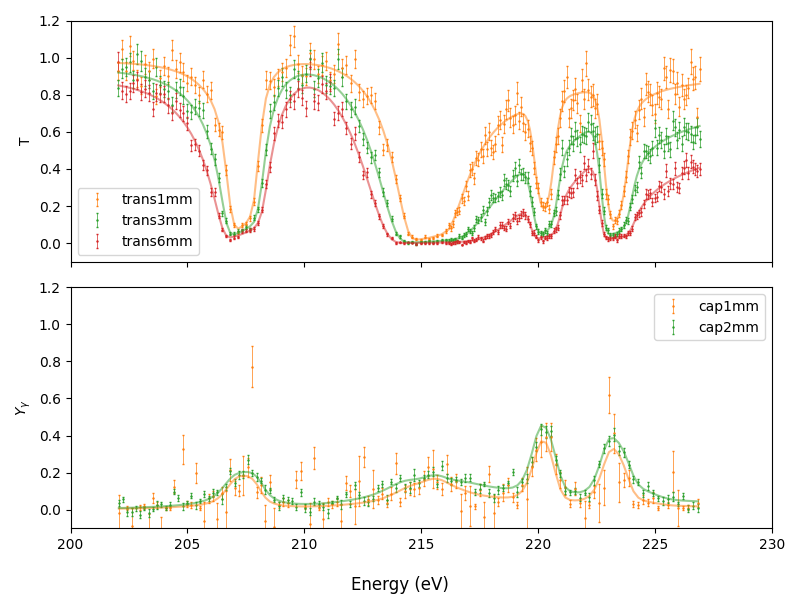

In [24]:
### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

colors = ["C1", "C2", "C3", "C4"]
### Trans
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm']):

    axes[0].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)

    axes[0].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[it], alpha=0.5)

axes[0].set_ylabel("T")

### Capture
for ic, key in enumerate(['cap1mm', 'cap2mm']):
    axes[1].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0, 
                                            fmt='.', color=colors[ic], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    axes[1].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[ic], alpha=0.5)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,230])
    ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [25]:
# a try to calc all noise chars for one dataset generated
# let's analyze the signal for one sample

# calculcate for all cases but for specific dataset

# dataset key
sel_key = 'trans1mm'

CoV_s = []
mSNR_s = []
mUP_s = []
uSR_s = []
chi2_to_true_s = [] # chi2 of the true to data

exp = sample1[sel_key].pw_reduced.exp
unc = sample1[sel_key].pw_reduced.exp_unc

CoV = elim_addit_funcs.coefficient_of_variation(exp)
mSNR = elim_addit_funcs.mean_signal_to_noise_ratio(exp, unc )
mUP = elim_addit_funcs.mean_uncertainty_percentage(exp, unc )

uSR = elim_addit_funcs.uncertainty_to_signal_ratio(exp, unc)

print(key)
print(f'CoV: {CoV}')
print(f'mSNR: {mSNR}') #dB
print(f'mUP: {mUP}') # %
print(f'uSR: {uSR}')


cap2mm
CoV: 0.4911577511948651
mSNR: 24.00907328010602
mUP: 8.010865736390313
uSR: 0.0655102212667991


In [31]:
# covariance matrix

sample_cov_data = sample1[sel_key].covariance_data
signal_data = sample1[sel_key].pw_reduced[['E', 'exp']]


diag_elements = sample_cov_data['diag_stat'].iloc[:, 0].values
diag_matrix = np.diag(diag_elements)

print(f"Jac_sys shape {sample_cov_data['Jac_sys'].shape}")
print(f"Cov_sys shape {sample_cov_data['Cov_sys'].shape}")
print(f"diag_stat shape {sample_cov_data['diag_stat'].shape}")

full_cov = sample_cov_data['Jac_sys'].T @ sample_cov_data['Cov_sys'] @ sample_cov_data['Jac_sys'] + diag_matrix 
#full_cov = sample_cov_data['Jac_sys'] @ sample_cov_data['Cov_sys'] @ sample_cov_data['Jac_sys'].T + diag_matrix 

print(full_cov.shape)
print(full_cov)

print(signal_data.shape)
print(signal_data)

Jac_sys shape (10, 199)
Cov_sys shape (10, 10)
diag_stat shape (199, 1)
(199, 199)
E           202.036981  202.199565  202.362345  202.525321  202.688494  \
E                                                                        
202.036981    0.002321    0.000598    0.000532    0.000610    0.000565   
202.199565    0.000598    0.002786    0.000596    0.000684    0.000633   
202.362345    0.000532    0.000596    0.002304    0.000608    0.000563   
202.525321    0.000610    0.000684    0.000608    0.003038    0.000646   
202.688494    0.000565    0.000633    0.000563    0.000646    0.002616   
...                ...         ...         ...         ...         ...   
226.522995    0.000561    0.000628    0.000558    0.000641    0.000593   
226.619477    0.000509    0.000570    0.000507    0.000581    0.000538   
226.716020    0.000513    0.000575    0.000511    0.000586    0.000543   
226.812625    0.000390    0.000437    0.000389    0.000446    0.000413   
226.909292    0.000538    0.0

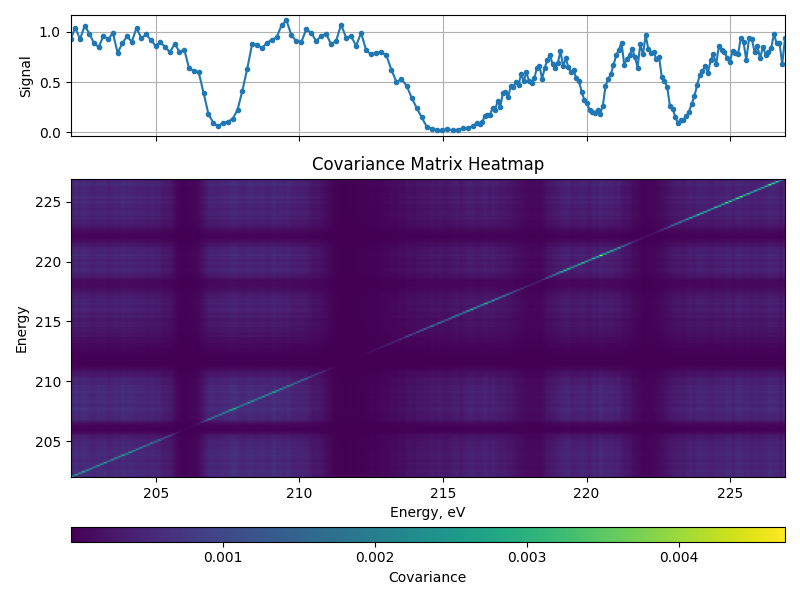

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

# Plot the signal data 
ax1.plot(signal_data['E'], signal_data['exp'], '-o', markersize=3)
ax1.set_ylabel('Signal')
ax1.grid(True)

# Plot the covariance matrix 
energy_values = full_cov.columns.values

im = ax2.imshow(full_cov, aspect='auto', origin='lower',
                extent=[energy_values[0], energy_values[-1], energy_values[0], energy_values[-1]],
                cmap='viridis')
ax2.set_ylabel('Energy')
ax2.set_title('Covariance Matrix Heatmap')

# C axis for the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# colorbar in the newly created axis, oriented horizontally
plt.colorbar(im, cax=cax, orientation='horizontal', label='Covariance')

ax2.set_xlabel('Energy, eV')

plt.tight_layout() 

plt.show()
